In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()
%matplotlib inline

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae

from sklearn.model_selection import KFold, cross_validate, cross_val_score
import scipy.stats as st

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import warnings 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
# Load and view data
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')

X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

pd.set_option('display.max_columns', None)

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1168, 117)
(1168, 1)
(292, 117)
(292, 1)


# 1. First Linear Regression Model

In this model, I ran a straight forward Linear Regression Model.

In [4]:
# Linear Regression Model
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
    
y_pred = lr.predict(X_test) 

mse = mean_squared_error(y_test, y_pred)
rmse1 = np.sqrt(mse)

round(rmse1, 2)

34044.04

In [5]:
# RMSE range
y_test_mean = np.mean(y_test)

lower = y_test_mean - rmse1
upper = y_test_mean + rmse1

print(str(round(lower[0], 2)) +'\n'+ str(round(upper[0], 2)))

144795.77
212883.86


In [6]:
# Root Mean Square Percent Error
rmspe1 = (np.sqrt(np.mean(np.square((y_test - y_pred) / y_test)))) * 100
rmspe1[0]

17.091033580513024

In [7]:
# Calculate Mean Absolute Error
error = mae(y_test, y_pred)
  
# display
print("Mean absolute error : " + str(error))

Mean absolute error : 21260.00684931507


In [8]:
# Calculate Mean Absolute Percent Error
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    calc = np.mean(np.abs((actual - pred) / actual)) * 100
    return calc

mape1 = mape(y_test,y_pred)

print("Mean absolute percent error : " + str(mape1))

Mean absolute percent error : 12.295704942988314


# 2. Second Linear Regression Model

I seem to be having some trouble applying Cross validation to my Linear Regression Model. My RMSE value keeps coming out very very large.

In [9]:
k_folds = KFold(n_splits=5, random_state=42, shuffle=True)

scores = cross_val_score(lr, X_train, y_train, 
                         scoring="neg_mean_squared_error", cv = k_folds)

print("Cross Validation Scores: ", scores)
print("RMSE: ", np.sqrt(np.mean(np.absolute(scores))))
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [-9.27782702e+08 -3.55600702e+31 -9.29906876e+30 -8.05444206e+08
 -4.05403132e+29]
RMSE:  3008805149668394.5
Number of CV Scores used in Average:  5


# 3. Third Linear Regression Model

In this model, I observed the correlation between each column and the "Saleprice". I then tested removing lower correlation number to see how the RMSE changed. 

In [10]:
corr_dict={}
for col in X_train.columns:
    corr = X_train[col].corr(y_train['SalePrice'])
    corr_dict.update({col : np.abs(corr)})
    
corr_df = pd.DataFrame(corr_dict.items(),columns=['Column', 'Correlation'])\
                        .sort_values(by='Correlation',ascending=False)

corr_df

,Column,Correlation
2,OverallQual,0.785555
12,GrLivArea,0.695652
21,GarageCars,0.640991
22,GarageArea,0.624139
8,TotalBsmtSF,0.597766
...,...,...
45,RoofStyle_Mansard,0.006321
6,BsmtFinSF2,0.005731
111,Foundation_Wood,0.002776
110,Foundation_Stone,0.002416


In [11]:
corr_30 = corr_df[corr_df['Correlation'] > 0.04]
print(f'\033[1mNumber of remaining features:\033[0m {corr_30.shape[0]}')


Number of remaining features: 92


In [12]:
new_cols = list(corr_30['Column'])

In [13]:
new_cols

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'ExterQual_TA',
 'FullBath',
 'TotRmsAbvGrd',
 'Built_to_Sale',
 'KitchenQual_TA',
 'KitchenQual_Ex',
 'Years_Since_Remod',
 'Foundation_PConc',
 'MasVnrArea',
 'Fireplaces',
 'HeatingQC_Ex',
 'ExterQual_Gd',
 'ExterQual_Ex',
 'BsmtFinSF1',
 'Foundation_CBlock',
 'WoodDeckSF',
 'KitchenQual_Gd',
 'HeatingQC_TA',
 '2ndFlrSF',
 'OpenPorchSF',
 'HalfBath',
 'MSZoning_RM',
 'CentralAir_N',
 'CentralAir_Y',
 'LotArea',
 'LotShape_Reg',
 'HouseStyle_2Story',
 'RoofStyle_Hip',
 'PavedDrive_Y',
 'RoofStyle_Gable',
 'BsmtFullBath',
 'MSZoning_RL',
 'BsmtUnfSF',
 'PavedDrive_N',
 'LotShape_IR1',
 'Foundation_BrkTil',
 'HouseStyle_1.5Fin',
 'KitchenQual_Fa',
 'BedroomAbvGr',
 'HeatingQC_Gd',
 'LotConfig_CulDSac',
 'EnclosedPorch',
 'LandContour_HLS',
 'KitchenAbvGr',
 'BldgType_1Fam',
 'LotShape_IR2',
 'ExterCond_Fa',
 'HeatingQC_Fa',
 'Foundation_Slab',
 'Condition1_Feedr',
 'Functional_Typ',
 'ScreenPorch'

In [14]:
X_train2 = X_train[new_cols]
X_test2 = X_test[new_cols]

print(X_train.shape)
print(X_test.shape)
print(X_train2.shape)
print(X_test2.shape)

(1168, 117)
(292, 117)
(1168, 92)
(292, 92)


In [15]:
lr = linear_model.LinearRegression()
lr.fit(X_train2, y_train)
    
y_pred2 = lr.predict(X_test2) 

mse2 = mean_squared_error(y_test, y_pred2)
rmse2 = np.sqrt(mse2)

round(rmse2, 2)

34044.59

In [16]:
# Root Mean Square Percent Error
rmspe2 = (np.sqrt(np.mean(np.square((y_test - y_pred2) / y_test)))) * 100
rmspe2[0]

17.007386918942736

In [17]:
# calculate Mean Absolute Error
error2 = mae(y_test, y_pred2)
  
# display
print("Mean absolute error : " + str(error2))

Mean absolute error : 21274.763698630137


In [18]:
mape2 = mape(y_test,y_pred2)

print("Mean absolute percent error : " + str(mape2))

Mean absolute percent error : 12.24988277983894


In [19]:
correlations = np.arange(0.0, 0.7, 0.01)

RMSEs = []
RMSPEs = []
MAEs = []
MAPEs = []

for corr in correlations:
    corr_new2 = corr_df[corr_df['Correlation'] > corr]
    
    new_cols = list(corr_new2['Column'])
    
    X_train_new = X_train[new_cols]
    X_test_new = X_test[new_cols]
    
    lr = linear_model.LinearRegression()
    lr.fit(X_train_new, y_train)
    y_pred_new = lr.predict(X_test_new) 
    
    mse_new = mean_squared_error(y_test, y_pred_new)
    rmse_new = np.sqrt(mse_new)
    RMSEs.append(round(rmse_new, 2))
    
    # Root Mean Square Percent Error
    rmspe_new = (np.sqrt(np.mean(np.square((y_test - y_pred_new) / y_test)))) * 100
    
    
    # calculate Mean Absolute Error
    error_new = mae(y_test, y_pred_new)
    MAEs.append(round(error_new, 2))
    mape_new = mape(y_test,y_pred_new)
    
    RMSPEs.append(rmspe_new[0])
    MAPEs.append(mape_new)


In [20]:
# Min at corr = 0.07
RMSE_corr_min = min(RMSEs) 
RMSPE_corr_min = min(RMSPEs)

In [21]:
# Min at corr = 0.04
MAE_corr_min = min(MAEs) 
MAPE_corr_min = min(MAPEs)
MAPE_corr_min

12.24988277983894

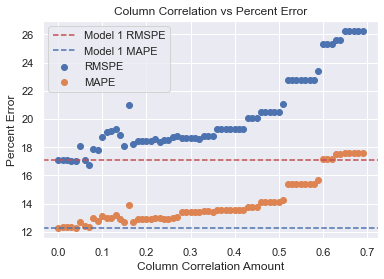

In [22]:
plt.scatter(x=correlations, y=RMSPEs)
plt.scatter(x=correlations, y=MAPEs)

plt.axhline(rmspe1[0], color = 'r', linestyle = '--', label = 'Model 1 RMSPE')
plt.axhline(mape1, color = 'b', linestyle = '--', label = 'Model 1 MAPE')

plt.title('Column Correlation vs Percent Error')
plt.xlabel('Column Correlation Amount')
plt.ylabel('Percent Error')

plt.legend(['Model 1 RMSPE', 'Model 1 MAPE', 'RMSPE', 'MAPE'])
plt.show()

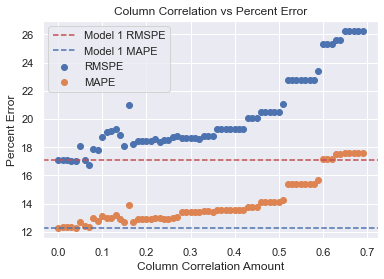

In [23]:
plt.scatter(x=correlations, y=RMSPEs)
plt.scatter(x=correlations, y=MAPEs)

plt.axhline(rmspe1[0], color = 'r', linestyle = '--', label = 'Model 1 RMSPE')
plt.axhline(mape1, color = 'b', linestyle = '--', label = 'Model 1 MAPE')

plt.title('Column Correlation vs Percent Error')
plt.xlabel('Column Correlation Amount')
plt.ylabel('Percent Error')

plt.legend(['Model 1 RMSPE', 'Model 1 MAPE', 'RMSPE', 'MAPE'])
plt.show()

# 4. Random Forest Model

In [24]:
rf = RandomForestRegressor(random_state=42)

rf.fit(X_train, y_train.values.ravel())  

y_pred3 = rf.predict(X_test) 

mse3 = mean_squared_error(y_test, y_pred3)
rmse3 = np.sqrt(mse3)

round(rmse3, 0)

27763.0

In [25]:
y_pred3 = y_pred3.reshape(292,1)

# Root Mean Square Percent Error
rmspe3 = (np.sqrt(np.mean(np.square((y_test - y_pred3) / y_test)))) * 100
rmspe3[0]

18.18019480599643

In [26]:
# calculate Mean Absolute Error
error3 = mae(y_test, y_pred3)
  
# display
print("Mean absolute error : " + str(error3))

Mean absolute error : 17505.4601826484


In [27]:
mape3 = mape(y_test,y_pred3)

print("Mean absolute percent error : " + str(mape3))

Mean absolute percent error : 10.665555030964459


# 5. Random Forest Model Hyperparameter Optimization
 
Using RandomizedSearchCV searching for the best hyperparameters.

In [28]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train.values.ravel())

# Best params
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
#Apply best params
  
rf2 = RandomForestRegressor(n_estimators= 400, min_samples_split= 2,
                            min_samples_leaf= 1, max_features= 'sqrt',
                            max_depth= None, bootstrap= False, random_state=42)


rf2.fit(X_train, y_train.values.ravel())  

y_pred4 = rf2.predict(X_test) 

mse4 = mean_squared_error(y_test, y_pred4)
rmse4 = np.sqrt(mse4)

round(rmse4, 0)

In [ ]:
y_pred4 = y_pred4.reshape(292,1)

# Root Mean Square Percent Error
rmspe4 = (np.sqrt(np.mean(np.square((y_test - y_pred4) / y_test)))) * 100
rmspe4[0]

In [ ]:
# calculate Mean Absolute Error
error4 = mae(y_test, y_pred4)
  
# display
print("Mean absolute error : " + str(error4))

In [ ]:
mape4 = mape(y_test,y_pred4)

print("Mean absolute percent error : " + str(mape4))

# 6. Random Forest Model Hyperparameter Optimization
 
Using GridSearchCV searching for the best hyperparameters.

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
    
# Create a based model
rf3 = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf3, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)


In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train.values.ravel())
grid_search.best_params_

In [ ]:
rf3 = RandomForestRegressor(n_estimators= 100, min_samples_split= 8,
                            min_samples_leaf= 3, max_features= 3,
                            max_depth= 100, bootstrap= True, random_state=42)


rf3.fit(X_train, y_train.values.ravel())  

y_pred5 = rf3.predict(X_test) 

mse5 = mean_squared_error(y_test, y_pred5)
rmse5 = np.sqrt(mse5)

round(rmse5, 0)

In [ ]:
y_pred5 = y_pred5.reshape(292,1)

# Root Mean Square Percent Error
rmspe5 = (np.sqrt(np.mean(np.square((y_test - y_pred5) / y_test)))) * 100
rmspe5[0]

In [ ]:
# calculate Mean Absolute Error
error5 = mae(y_test, y_pred5)
  
# display
print("Mean absolute error : " + str(error5))

In [ ]:
mape5 = mape(y_test,y_pred5)

print("Mean absolute percent error : " + str(mape5))

# 7. Results Dataframe

In [ ]:
error_df = pd.DataFrame([('1st LR Model', rmse1, rmspe1[0], error, mape1),
                  ('LR CORR Model', RMSE_corr_min, RMSPE_corr_min, MAE_corr_min, MAPE_corr_min),
                  ('1st RF Model', rmse3, rmspe3[0], error3, mape3), 
                  ('RF RandCV Model', rmse4, rmspe4[0], error4, mape4),
                  ('RF GridCV Model',rmse5, rmspe5[0], error5, mape5)], 
                 columns = ['Name','RMSE', 'RMSPE','MAE',"MAPE"])

error_df

In [ ]:
df = pd.DataFrame(dict(graph= error_df['Name'],
                           n=error_df['RMSPE'], m=error_df['MAPE'])) 

ind = np.arange(len(df))
width = 0.4

fig, ax = plt.subplots()
ax.barh(ind, df.n, width, color='blue', label='RMSPE')
ax.barh(ind + width, df.m, width, color='red', label='MAPE')

ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])

ax.legend()
plt.xlabel('Percent Error')
plt.gca().invert_yaxis()
plt.show()

# 8. Generating Prices from Random Data

Here I used random entries from the previous training data to predict the price of a house.

In [ ]:
# Load and view data
pre_scaled = pd.read_csv('pre_scaled.csv')
pd.set_option('display.max_columns', None)

In [ ]:
import random

data = {}

random.seed(42)

for feature in X_train.columns:
    random.seed(42)
    data[feature] = np.random.choice(X_train[feature], 3).tolist()

houses_new = pd.DataFrame(data)



#houses_new = houses_new[cols]

houses_new.shape

In [ ]:
#Apply best params
  
rf2 = RandomForestRegressor(n_estimators= 400, min_samples_split= 2,
                            min_samples_leaf= 1, max_features= 'sqrt',
                            max_depth= None, bootstrap= False, random_state=42)

rf2.fit(X_train, y_train.values.ravel())  
y_pred_random = rf2.predict(houses_new)

houses_new_SalePrice = y_pred_random

houses_new_SalePrice


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(pre_scaled)

data = scaler.inverse_transform(houses_new)

In [ ]:
data = pd.DataFrame(np.array(data),columns=pre_scaled.columns)

In [ ]:
data['SalePrice'] = houses_new_SalePrice

data

In [ ]:
cols = ['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 
        '1stFlrSF', 'FullBath', 'Built_to_Sale', 'Years_Since_Remod', 'TotRmsAbvGrd']
data_new = data[cols] 
data_new